# Loading rh outputs and defining various constants

In [1]:
#%matplotlib inline
#%matplotlib widget
#%matplotlib ipympl
from helita.sim import rh15d
from helita.vis import rh15d_vis
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c, h, k_B
import astropy.units as units

# close data if already loaded
try:
    data.close()
except:
    pass



# rest frame h and k line in air (https://iris.lmsal.com/itn39/Mg_diagnostics.html)
wl_k_rest = 1e7/35760.875 * units.nm   # from MgII-IRIS.atom

col_idx = [0,0]     # define column to investigate

data = rh15d.Rh15dout()
height = data.files[1].height_scale[col_idx[0], col_idx[1]]
height = np.array(height) * units.Unit(height.units)      # define as simple array with unit (not xarray)
height = np.nan_to_num(height, nan=np.infty)

--- Read ./output_aux.hdf5 file.
--- Read ./output_indata.hdf5 file.
--- Read ./output_ray.hdf5 file.


/mn/stornext/u3/jonastf/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:40: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  setattr(self, g, xr.open_dataset(infile, group=g, autoclose=True))
/mn/stornext/u3/jonastf/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:53: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  self.ray = xr.open_dataset(infile, autoclose=True)


In [2]:
# adjust plot figure and labels in appropiate sizes
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 7),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

--------------------------

# Attributes in datafile

In [3]:
print("-------------------------------------------------------------------------------------\n")
for i, files in enumerate(data.files):
    print("data.files[%i]" % i)
    print(files,"\n\n-------------------------------------------------------------------------------------\n")

-------------------------------------------------------------------------------------

data.files[0]
<xarray.Dataset>
Dimensions:          (height: 1024, level: 11, phony_dim_4: 10, phony_dim_5: 15, x: 1, y: 1)
Coordinates:
  * x                (x) float64 8.867e+06
  * y                (y) float64 -4.451e+06
Dimensions without coordinates: height, level, phony_dim_4, phony_dim_5
Data variables:
    continuum        (phony_dim_4) uint32 ...
    line             (phony_dim_5) uint32 ...
    populations      (level, x, y, height) float32 ...
    populations_LTE  (level, x, y, height) float32 ...
Attributes:
    nlevel:      11
    nline:       15
    ncontinuum:  10 

-------------------------------------------------------------------------------------

data.files[1]
<xarray.Dataset>
Dimensions:            (element: 99, height: 1024, ray: 5, x: 1, y: 1)
Coordinates:
  * x                  (x) float64 8.867e+06
  * y                  (y) float64 -4.451e+06
Dimensions without coordinates: 

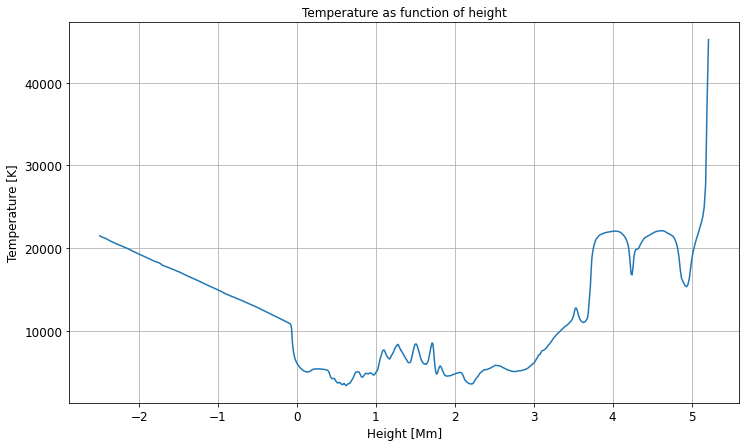

In [4]:
plt.figure()
plt.plot(height*1e-6, data.atmos.temperature[col_idx[0], col_idx[1]])
plt.xlabel("Height [Mm]"); plt.ylabel("Temperature [K]")
plt.title("Temperature as function of height")
plt.grid()
#plt.savefig("temp.pdf")

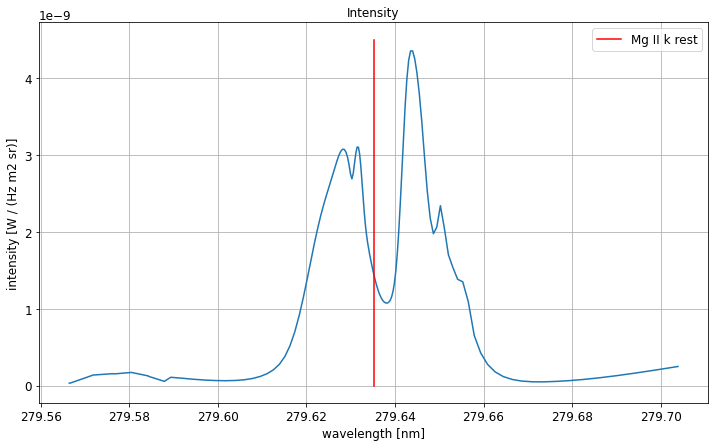

In [5]:
plt.figure()
#wave = data.ray.wavelength
wave = data.ray.wavelength_selected
wave = np.array(wave) * units.Unit(wave.units)      # define as simple array with unit (not xarray)
vac = 0.08 * units.nm       # used if VACUUM_TO_AIR = FALSE in keyword.input (just set 0 if TRUE)
min_wave, max_wave = 279*units.nm+vac, 280.8*units.nm+vac
#indices = np.arange(len(wave))[(wave > min_wave) & (wave < max_wave)]      # want to add these indices to ray.input
indices = np.array(data.files[4].wavelength_indices)       # using these indices instead. indices representing wavelength of interest
data.ray.intensity[col_idx[0], col_idx[1]][indices].plot()
plt.plot([wl_k_rest.value, wl_k_rest.value], [0, 4.5e-9], label="Mg II k rest", color="Red")
plt.title("Intensity")
plt.grid()
plt.legend();

# Adding specific indices in `ray.input` and rerun rh for detailed outputs
Remember to move `ray.input` into the correct folder (from /run_project/output/'whatever_name_of_folder' to /run_project) before rerun.

In [6]:
"""
f = open("../ray.input", "w")  # this will overwrite any existing file!
f.write("1.00\n")
#output = str(len(indices))                    # includes all of the Mg II spectrum
#selected_indices = indices                    # includes all of the Mg II spectrum
output = str(len(idx_k))                       # only Mg II k profile
selected_indices = int(min(indices)) + idx_k   # only Mg II k profile
for ind in selected_indices:
    output += " %i" % ind
f.write(output)
f.close()
""";

In [7]:
mg_k = [279.5*units.nm+vac, 279.61*units.nm+vac]
idx_k = np.arange(len(wave))[(wave > mg_k[0]) & (wave < mg_k[1])]

I = data.ray.intensity[col_idx[0], col_idx[1]][indices]
I = np.array(I) * units.Unit(I.units)      # define as simple array with unit (not xarray)
I_k = I[idx_k]       # intensity around k line

wave_k = wave[idx_k]
idx_k_centre = np.where(np.min(abs(wave_k-wl_k_rest)) == abs(wave_k-wl_k_rest))[0]

while True:
    I_r = I_k[idx_k_centre+1][0]     # right of temporary centre
    I_l = I_k[idx_k_centre-1][0]     # left of temporary centre
    
    if I_r < I_k[idx_k_centre]:
        idx_k_centre += 1
    elif I_l < I_k[idx_k_centre]:
        idx_k_centre -= 1
    else:
        break
wl_k_centre = wave_k[idx_k_centre][0]


#c = constants.c.to("nm/s")
#dnu_k = (wl_k_rest - wave_k) / wl_k_rest * c * 1e-12                # converting to correct units (km/s)
#dnu_k_centre = (wl_k_rest - wl_k_centre) / wl_k_rest * c * 1e-12    # converting to correct units (km/s)
dnu_k = ((wl_k_rest - wave_k) / wl_k_rest * c).to("km/s")                # converting to correct units (km/s)
dnu_k_centre = ((wl_k_rest - wl_k_centre) / wl_k_rest * c).to("km/s")    # converting to correct units (km/s)

dnu_lim = 65 * units.Unit("km/s")
min_idx_k = min(idx_k)
idx_k = np.where(abs(dnu_k)<dnu_lim)[0] + min_idx_k     # redefine idx_k

# redefine parameters originally defined with idx_k and idx_h
dnu_k = dnu_k[idx_k-min_idx_k]
wave_k = wave[idx_k]
I_k = I[idx_k]       # intensity around k line

Doppler shift in Mg II k: 0.00294 nm
Wavelength of centre:     279.63815 nm


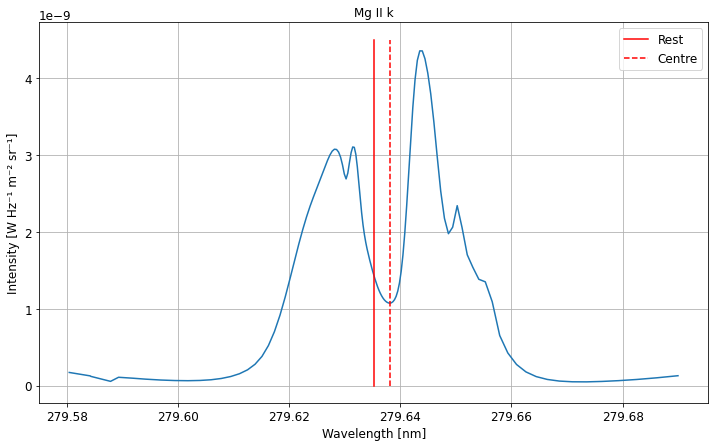

In [8]:
plt.figure(figsize=(12,7))
plt.plot(wave_k, I_k)
plt.plot([wl_k_rest.value, wl_k_rest.value], [0, 4.5e-9], label="Rest", color="Red")
plt.plot([wl_k_centre.value, wl_k_centre.value], [0, 4.5e-9], "--", label="Centre", color="Red")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [W Hz⁻¹ m⁻² sr⁻¹]")
plt.grid()
plt.legend()
plt.title("Mg II k")

dwl_k = wl_k_centre-wl_k_rest
print("Doppler shift in Mg II k: %.5f nm" % dwl_k.value)
print("Wavelength of centre:     %.5f nm" % wl_k_centre.value)

We note the centre is slighlty red-shifted. This means that the atmosphere in this column is moving towards what is defined as the negative direction. The atmosphere from Bifrost simulation has downflow as positive direction which means that the velocity of atmosphere is outgoing.

Converting wavelengths to $\Delta \nu$ [km/s] and replot.

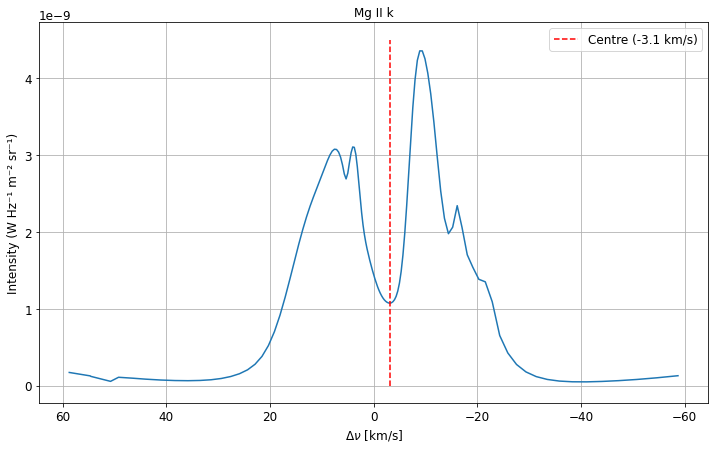

In [9]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(dnu_k, I_k)
ax.plot([dnu_k_centre.value, dnu_k_centre.value], [0, 4.5e-9], "--", label="Centre (%.1f km/s)" % dnu_k_centre.value, color="Red")
ax.set_xlabel(r"$\Delta \nu$ [km/s]")
ax.set_ylabel("Intensity (W Hz⁻¹ m⁻² sr⁻¹)")
ax.invert_xaxis()
ax.grid()
ax.legend()
ax.set_title("Mg II k");

# Source function and optical depth $\tau = 1$

Widget did not work properly

In [40]:
tau_one_height = data.files[4].tau_one_height[col_idx[0], col_idx[1]][indices]
tau_one_height = np.array(tau_one_height) * units.Unit(tau_one_height.units)      # define as simple array with unit (not xarray)

sf = data.files[4].source_function[col_idx[0], col_idx[1]]
sf = np.array(sf) * units.Unit(sf.units)      # define as simple array with unit (not xarray)


sf_tau_one = np.zeros(len(indices)) * units.Unit(sf.unit)

for i in range(len(indices)):
    idx_temp = np.argmin(abs(height - tau_one_height[i]))
    sf_tau_one[i] = sf[idx_temp, i]

tau_one_max = np.argmax(tau_one_height)        # max height where tau=1
sf_tau_one_blue = sf_tau_one[:tau_one_max]
sf_tau_one_red = sf_tau_one[tau_one_max:]


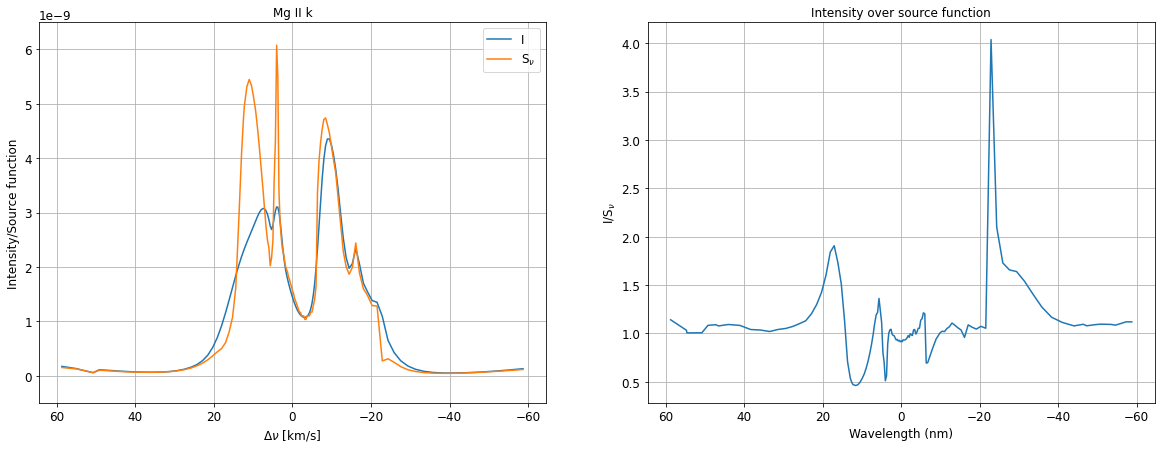

In [41]:
fig_I_and_sf, (ax_I_and_sf, ax_I_over_sf) = plt.subplots(1,2,figsize=(20,7))
ax_I_and_sf.plot(dnu_k, I[idx_k], label="I")
ax_I_and_sf.plot(dnu_k, sf_tau_one[idx_k], label=r"S$_{\nu}$")
ax_I_and_sf.set_ylim(-0.5e-9, 6.5e-9)
ax_I_and_sf.grid()
ax_I_and_sf.set_title("Mg II k")
ax_I_and_sf.set_xlabel(r"$\Delta \nu$ [km/s]")
ax_I_and_sf.set_ylabel("Intensity/Source function")
ax_I_and_sf.legend()
ax_I_and_sf.invert_xaxis()

ax_I_over_sf.plot(dnu_k, I[idx_k]/sf_tau_one[idx_k])
ax_I_over_sf.grid()
ax_I_over_sf.set_title("Intensity over source function")
ax_I_over_sf.set_xlabel("Wavelength (nm)")
ax_I_over_sf.set_ylabel(r"I/S$_{\nu}$")
ax_I_over_sf.invert_xaxis()
#ax_I_over_sf.set_ylim(-0.5e-9, 6.5e-9)

Text(0.5, 0, 'T [kK]')

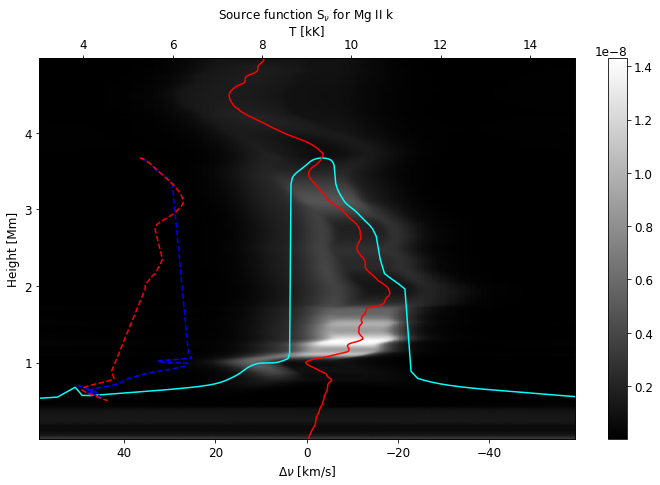

In [42]:
to_idx = np.where(abs(height) == np.min(abs(height[np.isfinite(height)])))[0][0]
from_idx = 120

vel_z = data.files[1].velocity_z[col_idx[0], col_idx[1],:]
vel_z = np.array(vel_z) * units.Unit(vel_z.units)      # define as simple array with unit (not xarray)
z = data.files[1].height_scale[col_idx[0], col_idx[1],:]
z = np.array(z) * units.Unit(z.units)      # define as simple array with unit (not xarray)



#bt = h * c / (wave[idx_k] * k_B * np.log(2 * h * c / (wave[idx_k]**3 * I_k * units.rad**2) + 1))   # converting intensity to brightness temperature
#Sline = h * c / (wave * k_B * np.log(2 * h * c / (wave**3 * sf_tau_one * units.rad**2) + 1))   # converting source function to brightness temperature
#Sline = Sline.to("K")
Sline_blue = h * c / (wave[:tau_one_max] * k_B * np.log(2 * h * c / (wave[:tau_one_max]**3 * sf_tau_one_blue * units.rad**2) + 1))   # converting source function to brightness temperature
Sline_blue = Sline_blue.to("K")
Sline_red = h * c / (wave[tau_one_max:] * k_B * np.log(2 * h * c / (wave[tau_one_max:]**3 * sf_tau_one_red * units.rad**2) + 1))   # converting source function to brightness temperature
Sline_red = Sline_red.to("K")



fig_sf, ax_sf_k = plt.subplots(figsize=(12,7))
plot_k = ax_sf_k.pcolormesh(dnu_k.value, height[from_idx:to_idx].value*1e-6, sf[from_idx:to_idx,idx_k].value, shading="gouraud", cmap="gray")
#ax_sf_k.plot([dnu_k_centre.value, dnu_k_centre.value], [0.5, 4.5], "--", label="Centre (%.1f [km/s])" % dnu_k_centre.value, color="green")
ax_sf_k.plot(dnu_k, tau_one_height[idx_k]*1e-6, color="cyan", label=r"$\tau$=1")
ax_sf_k.plot(vel_z*1e-3, z*1e-6, color="red", label=r"v$_{z}$")
ax_sf_k.set_title(r"Source function S$_{\nu}$ for Mg II k")
ax_sf_k.set_xlabel(r"$\Delta \nu$ [km/s]")
ax_sf_k.set_ylabel("Height [Mm]")
ax_sf_k.invert_xaxis()
#ax_sf_k.legend()
ax_sf_k.set_ylim(min(height[from_idx:to_idx]*1e-6).value, max(height[from_idx:to_idx]*1e-6).value)
fig_sf.colorbar(plot_k, ax=ax_sf_k)


par1 = plt.gca().twiny()
#par1.plot(T/1e3, height, linestyle[2], color=color[2])
#par1.plot(Sline/1e3, height, linestyle[3], color=color[3])
#par1.plot(Sline*1e-3, height[indices]*1e-6)
#par1.plot(Sline*1e-3, height*1e-6, color="white", label="S")
par1.plot(Sline_blue*1e-3, tau_one_height[:tau_one_max]*1e-6, "--", color="blue")
par1.plot(Sline_red*1e-3, tau_one_height[tau_one_max:]*1e-6, "--", color="red")
par1.set_xlim(3,15)
par1.set_xlabel("T [kK]")
#par1.grid(color='w') # Seems like you have to use twice to set grid color ?
#par1.grid(color='w')

# Run `lineform` for four-plots

No Contribution function scaling specified, setting to 1
No Color for the line plots specified, setting to default
No Linestyle for the line plots specified, setting to default


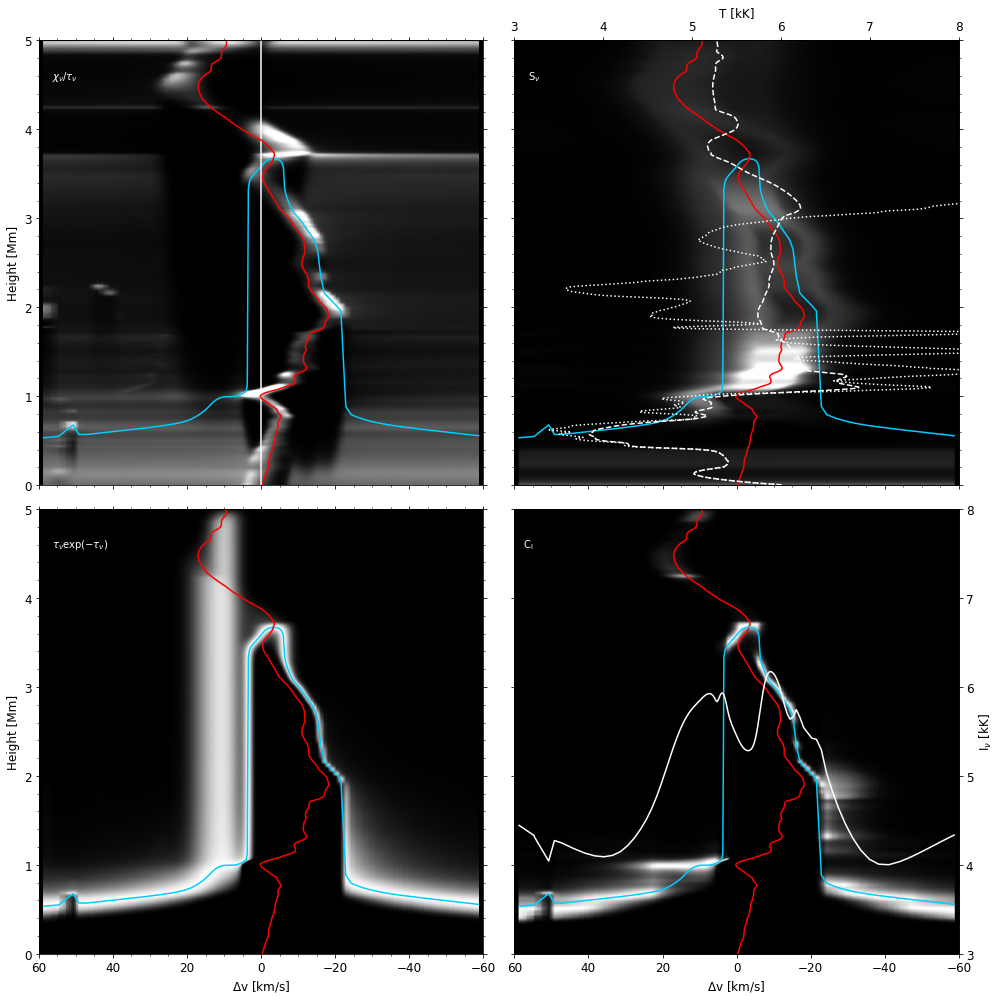

In [44]:
import lineform as lf

RHoutput = lf.Rh15d_calc(data)
RHoutput.formation_diagram(col_idx[0], col_idx[1],
                           wave_ref=wl_k_rest.value,
                           vrange=[-60,60],
                           sbtrange=[3, 8,5],
                           irange=[3, 8],
                           zrange=[0, 5])
#plt.savefig("lineform_test.pdf")

All plots:
- Cyan line: optical depth unity
- Red line: velocity z

Upper left plot:
- White line: $\Delta \nu = 0$

Upper right plot:
- White dotted line: temperature
- White dashed line: source function at rest wavelength

Lower right plot:
- White line: intensity in brightness temperature


In [129]:
cont = data.files[0].continuum
line = data.files[0].line
pop = data.files[0].populations
pop_lte = data.files[0].populations_LTE

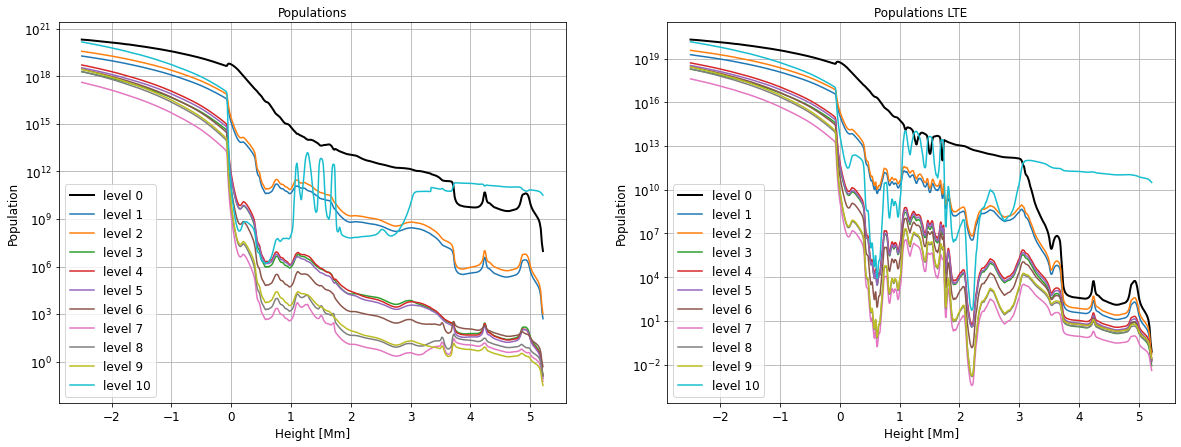

In [130]:
plt.figure(figsize=(20,7))

# first population
plt.subplot(121)
plt.title("Populations")
plt.plot(height*1e-6, pop[0,0,0,:], label="level 0", color="Black", lw=2)
# the rest of populations
for i in range(1, pop.shape[0]):
    plt.plot(height*1e-6, pop[i,0,0,:], label="level %i" % i)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Height [Mm]")
plt.ylabel("Population")

# first population
plt.subplot(122)
plt.title("Populations LTE")
plt.plot(height*1e-6, pop_lte[0,0,0,:], label="level 0", color="Black", lw=2)
# the rest of populations
for i in range(1, pop.shape[0]):
    plt.plot(height*1e-6, pop_lte[i,0,0,:], label="level %i" % i)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Height [Mm]")
plt.ylabel("Population");

# Terms and abbreviation

- Interface Region Imaging Spectrograph (IRIS)
- Local thermodynamic equilibrium (LTE)
- Partial frequency redistribution (PRD)
- Radiation-magnetohydrodynamic (RMHD)
- Complete redistribution (CRD)
- Transition region (TR)
- Joint probability density function (JPDF)
